In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import glob
import pandas as pd
from keplerdata import Dataset
plt.rcParams['figure.figsize'] = [12,10]
from tqdm import tqdm

In [54]:
datadir = '/Users/davies/Dropbox/K2_seismo_pipes/20Stars/Data/'
sfiles = glob.glob(datadir + '*.dat')
df = pd.read_csv(datadir + '20stars.csv')
#df = df[0:8]
dss = [Dataset(row.EPIC, datadir + 'kplr' + str(int(row.EPIC)) + '_llc_concat.dat') for idx, row in df.iterrows()]
for ds in tqdm(dss):
    ds.power_spectrum(dfN=(0.01, 28800))
    ds.rebin_quick(100)
power = [ds.smoo_power for ds in dss]
freq = dss[0].smoo_freq

100%|██████████| 23/23 [00:09<00:00,  2.39it/s]


In [124]:
data = np.zeros([len(dss[0].smoo_power), len(dss)])
for idx, p in enumerate(power):
    data[:,idx] = p
print(df)
numaxs = df.numax.values
kps = df.kic_kepmag.values
teffs = df.Teff.values
dnus = df.Dnu.values
masses = (numaxs / 3090.0)**3 * (dnus / 135.1)**-4 * (teffs / 5777.0)**1.5
#freq = freq[2:]
#data = data[2:, :]

    Unnamed: 0      EPIC   numax   Dnu    Teff  [M/H]2  kic_kepmag
0           67  10587122   37.36  4.33  4610.0    0.17    9.210000
1           68  10522084   45.76  4.72  4787.0   -0.01    9.246000
2          105  11550492   93.01  8.66  4685.0   -0.06    9.281000
3          110  11234897   61.32  5.15  4972.0    0.15    9.274000
4          122  11600024   35.72  4.25  4825.0   -0.21    9.119000
5          128  11496569   66.35  6.16  4849.0    0.04    9.440000
6          197  11615617  103.54  8.12  5065.0    0.26    9.078000
7          332  11969378   38.10  4.33  4849.0    0.06    9.469000
8          336  11819363   49.97  5.31  4915.0   -0.54    9.393000
9          347  11665692   67.79  5.95  4891.0    0.43    9.220000
10         491  11029423   74.38  7.23  4682.0   -0.05    9.476000
11         562   9517698   42.22  4.55  4855.0    0.06    9.185000
12         576   9518802   92.00  7.18  5187.0   -0.10    9.207000
13         728   8543200   40.75  4.44  4968.0   -0.15    9.40

Text(0,0.5,'Rebinned power')

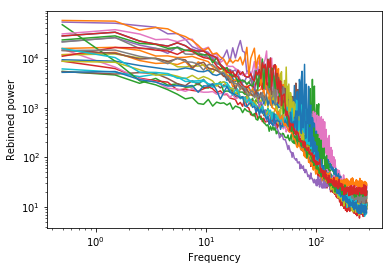

In [125]:
fig, ax = plt.subplots()
for idx, d in enumerate(data[0,:]):
    plt.plot(freq, data[:, idx])
ax.plot(freq, data[:,0])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Frequency')
ax.set_ylabel('Rebinned power')

Text(0,0.5,'High frequency noise')

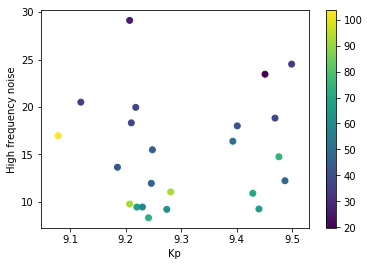

In [126]:
whites = np.median(data[-3:,:], axis=0)

fig, ax = plt.subplots()
CS = ax.scatter(kps, whites, c=numaxs)
cbar = fig.colorbar(CS)
ax.set_xlabel('Kp')
ax.set_ylabel('High frequency noise')

3.52 3.55 6.93


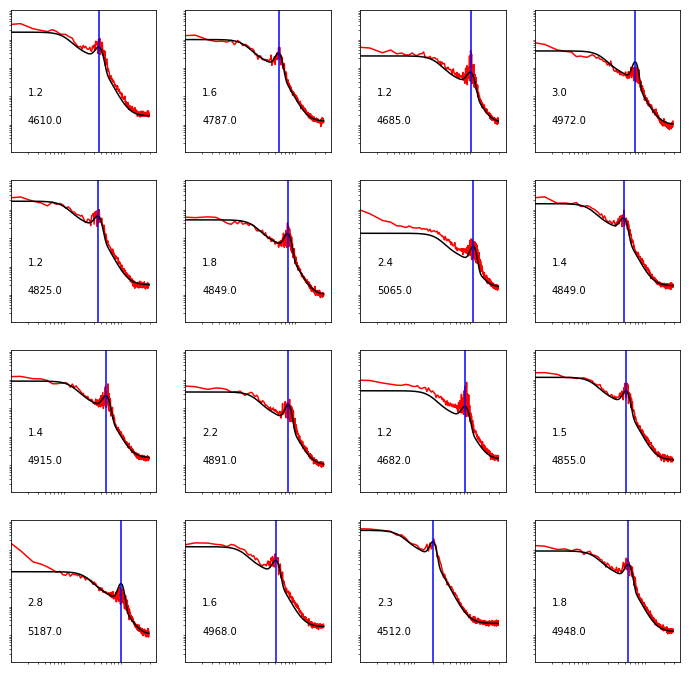

In [175]:
def harvey(f, a, b, c=4.0):
    return 0.9*a**2/b/(1 + (f/b)**c)
def gaussian(f, numax, width, height):
    return height * np.exp(-0.5 * (f - numax)**2 / width**2)
def apod(f, nyq):
    x = f / 2.0 / nyq
    
    return np.sinc(x)**2
def model(f, ak, ae, at, bk, be, ck, ce, ct, dk, de, numax, wk, we, wt, hk, he, white, mass):
    a = 10**(ak + numax*ae + mass*at)
    b = 10**(bk + numax*be)
    c = 10**(ck + numax*ce + mass*ct)
    d = 10**(dk + numax*de)
    width = 10**(wk + numax*we + mass*wt)
    height = 10**(hk + numax*he)
    model = (apod(f, 288.8) * (harvey(f, a, b) + harvey(f, c, d) + gaussian(f, 10**numax, width, height))) + 10**white
    return model
ak, ae, at = 3.52, -0.58, -0.26
bk, be = -0.48, 0.94
ck, ce, ct = 3.55, -0.64, -0.26
dk, de = 0.01, 0.97
wk, we = -0.83, 1.0
hk, he, wt = 6.93, -2.14, -0.3
print(ak, ck, hk)
n = 4
fig, ax = plt.subplots(n,n, figsize=[12, 12])
for i in range(0, n*n):
    x = i // n
    y = i % n
    fit0 = model(freq, 
                 ak, ae, at, bk, be, 
                 ck, ce, ct, dk, de, np.log10(numaxs[i]), 
                 wk, we, wt, hk, he, 
                 np.log10(whites[i]), np.log10(masses[i]))
    ax[x,y].plot(freq, data[:,i], 'r-')
    ax[x,y].plot(freq, fit0, 'k-')
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')
    ax[x, y].set_ylim([1, 1e5])
    ax[x, y].set_xlim([1 ,388])
    ax[x, y].axvline(numaxs[i], c='b')
    ax[x, y].set_yticks([])
    ax[x, y].set_xticks([])
    ax[x, y].text(2, 1e1, str(np.round(teffs[i])))
    ax[x, y].text(2, 1e2, str(np.round(masses[i] * 10.)/10.0))

In [7]:
print(numaxs)
print(whites)

[ 35.72  66.35 103.54  38.1 ]
[20.50377464  9.24258305 16.9751211  18.82045488]


The gamma function in stan is parameterised in a way I'm not used to (wiki says the stan way is common in Bayesian stats).  Let's investigate.

${\rm Gamma}(\alpha, \beta) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} x^{\alpha - 1} e^{-\beta x}$.

This parameterisation gives a mean value $\frac{\alpha }{\beta}$ and a variance of $\frac{\alpha}{\beta^{2}}$.  $\alpha$ is called the shape and $\beta$ is called the rate.

$\alpha$ is the same parameter as the shape $k$ in my familiar notation.  The rate $\beta$ is then the recipricol of the scale, i.e., $\theta = \frac{1}{\beta}$.

When fitting a power spectrum the data are the model multiplied by the noise distribution.  If we calculate the data divided by the model we are left with the noise distirbution.  

In [177]:
code = '''
functions {
    real harvey(real f, real a, real b, real c){
        return 0.9*a^2/b/(1.0 + (f/b)^c);
    }
    real gaussian(real f, real numax, real width, real height){
        return height * exp(-0.5 * (f - numax)^2 / width^2);
    }
    real apod(real f, real nyq){
        real x = 3.14 / 2.0 * f / nyq;
        return (sin(x) / x)^2;
    }
}
data {
    int N;
    int M;
    int dof;
    vector[N] f;
    real p[N, M];
    vector[M] numax_est;
    vector[M] white_est;
    vector[M] mass_est;

}
parameters {
    real<lower = 0> numax[M];
    real<lower = 0> white[M];
    real mass[M];
    real ae;
    real be;
    real ce;
    real de;
    real ak;
    real bk;
    real ck;
    real dk;
    real at;
    real ct;
    real wk;
    real we;
    real wt;
    real hk;
    real he; 
}
transformed parameters {
    vector[M] a;
    vector[M] b;
    vector[M] c;
    vector[M] d;
    vector[M] w;
    vector[M] h;
    for (j in 1:M){
        a[j] = 10^(ak + numax[j] * ae + mass[j] * at);
        b[j] = 10^(bk + numax[j] * be);
        c[j] = 10^(ck + numax[j] * ce + mass[j] * ct);
        d[j] = 10^(dk + numax[j] * de);
        w[j] = 10^(wk + numax[j] * we + mass[j] * wt);
        h[j] = 10^(hk + numax[j] * he);
    }
}
model {
    real beta[N, M];
    for (j in 1:M){
        for (i in 1:N){
            beta[i, j] = dof / (apod(f[i], 288.8)
                        * (harvey(f[i], a[j], b[j], 4.0)
                        + harvey(f[i], c[j], d[j], 4.0)
                        + gaussian(f[i], 10^numax[j], w[j], h[j]))
                        + 10^white[j]);
        }
        p[1:N, j] ~ gamma(dof, beta[1:N, j]);
    }
    ak ~ normal(3.45, 0.01); // log10
    ae ~ normal(-0.51, 0.01);
    at ~ normal(-0.26, 0.01);
    bk ~ normal(-0.46, 0.01); //log10
    be ~ normal(0.89, 0.01);
    ck ~ normal(3.59, 0.01); // log10
    ce ~ normal(-0.61, 0.01);
    ct ~ normal(-0.39, 0.01);
    dk ~ normal(0.04, 0.01); //log10
    de ~ normal(0.95, 0.01);
    wk ~ normal(-0.83, 0.005); // log10
    we ~ normal(1.0, 0.01);
    wt ~ normal(-0.3, 0.01);
    hk ~ normal(6.93, 0.008); // log10
    he ~ normal(-2.18, 0.005);
    numax ~ normal(numax_est, 0.01);
    white ~ normal(white_est, 0.01);
    mass ~ normal(mass_est, 0.03);
}
'''
sm = pystan.StanModel(model_code=code, model_name='backfit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL backfit_05d7c3a1835b09b60c04831ff39a0e01 NOW.


/usr/local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


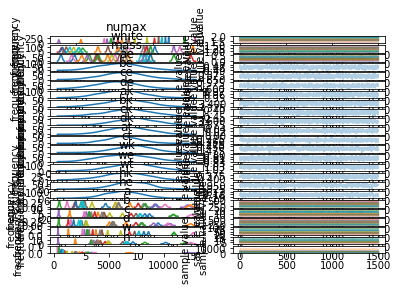

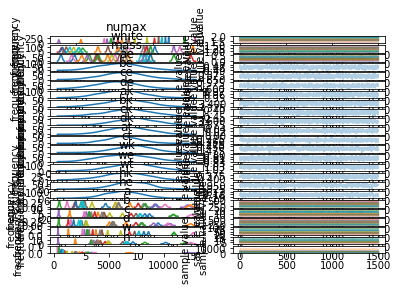

In [183]:
dat = {'N': len(freq),
       'M': len(numaxs),
       'dof': 100,
      'f': freq,
      'p': data,
      'numax_est': np.log10(numaxs),
      'white_est': np.log10(whites),
      'mass_est': np.log10(masses)}
# Note dof is not actually dof but is in fact the number of bins over which we have smoothed.
fit = sm.sampling(data=dat, iter=3000, chains=1)
fit.plot()

In [184]:
print(fit)

Inference for Stan model: backfit_05d7c3a1835b09b60c04831ff39a0e01.
1 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=1500.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
numax[0]    1.58  4.8e-5 1.8e-3   1.58   1.58   1.58   1.58   1.58   1500    1.0
numax[1]    1.68  4.3e-5 1.7e-3   1.67   1.67   1.68   1.68   1.68   1500    1.0
numax[2]    1.97  3.1e-5 1.2e-3   1.97   1.97   1.97   1.97   1.97   1500    1.0
numax[3]    1.81  4.4e-5 1.7e-3   1.81   1.81   1.81   1.81   1.81   1500    1.0
numax[4]    1.56  5.3e-5 2.0e-3   1.56   1.56   1.56   1.56   1.56   1500    1.0
numax[5]    1.83  3.2e-5 1.2e-3   1.83   1.83   1.83   1.83   1.83   1500    1.0
numax[6]    2.02  3.5e-5 1.3e-3   2.02   2.02   2.02   2.02   2.02   1406    1.0
numax[7]    1.59  4.7e-5 1.7e-3   1.59   1.59   1.59    1.6    1.6   1391    1.0
numax[8]    1.71  4.4e-5 1.6e-3    1.7    1.7   1.71   1.71   1.71   1282    1.0
numa

In [185]:
diff = 10**fit['numax'].mean(axis=0) - numaxs
print(diff)

[ 0.6834249   1.55946428 -0.11010931  3.14273209  0.64715354  1.39283174
  1.56116988  1.16349942  0.81960175  2.66522198 -0.77263965  1.25016243
  0.68109668  0.69918853  0.43485668  0.82014195  0.50893385  0.6913338
  1.27836944  0.38517702  2.64258916 -0.24329547  0.3296598 ]


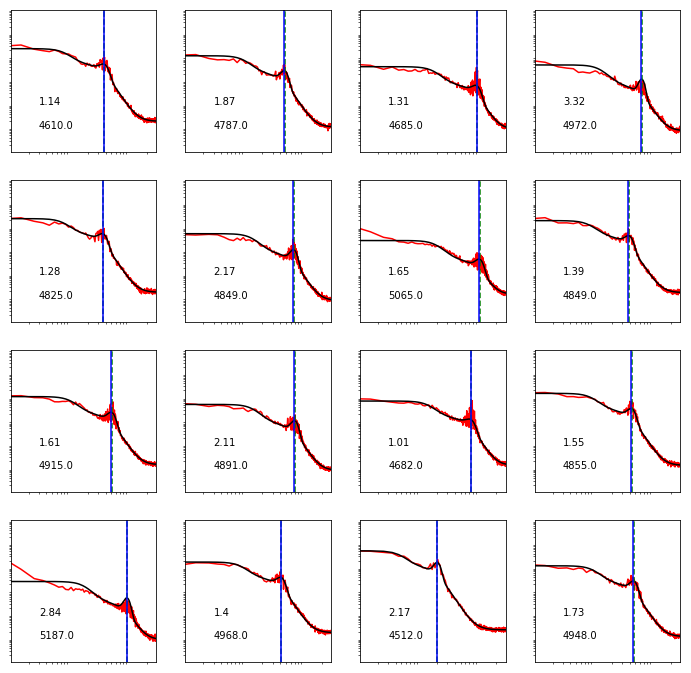

In [186]:
n = 4
fig, ax = plt.subplots(n,n, figsize=[12, 12])
ak = fit['ak'].mean()
ae = fit['ae'].mean()
at = fit['at'].mean()
bk = fit['bk'].mean()
be = fit['be'].mean()
ck = fit['ck'].mean()
ce = fit['ce'].mean()
ct = fit['ct'].mean()
dk = fit['dk'].mean()
de = fit['de'].mean()
wk = fit['wk'].mean()
we = fit['we'].mean()
wt = fit['wt'].mean()
hk = fit['hk'].mean()
he = fit['he'].mean()
numax = fit['numax'].mean(axis=0)
white = fit['white'].mean(axis=0)
mass = fit['mass'].mean(axis=0)
mass_err = np.std(fit['mass'], axis=0)
for i in range(0, n*n):
    fit0 = model(freq, ak, ae, at, bk, be, ck, ce, ct, dk, de, numax[i], wk, we, wt, hk, he, white[i], mass[i])
    x = i // n
    y = i % n
    ax[x, y].plot(freq, data[:,i], 'r-')
    ax[x, y].plot(freq, fit0, 'k-')
    ax[x, y].set_xscale('log')
    ax[x, y].set_yscale('log')
    ax[x, y].set_ylim([1, 1e6])
    ax[x, y].set_xlim([1 ,288])
    ax[x, y].axvline(10**numax[i], c='g', linestyle='--')
    ax[x, y].axvline(numaxs[i], c='b')
    ax[x, y].set_yticks([])
    ax[x, y].set_xticks([])
    ax[x, y].text(3, 10, str(np.round(teffs[i])))
    ax[x, y].text(3, 100, str(np.round(10**mass[i] * 100)/100.0))